In [86]:
import matplotlib.pyplot as plt
%matplotlib widget

In [87]:
import sys
sys.path.append("/richmondvol1/rusty/stompy")
from stompy import utils, memoize, xr_utils, xr_transect
import stompy.model.delft.dflow_model as dfm
import stompy.model.delft.waq_scenario as dwaq
from stompy.plot import plot_utils, plot_wkb, mkanim

from stompy.grid import unstructured_grid
from matplotlib import colors, cm
import matplotlib.colorbar as cbar
import pandas as pd
import os
import numpy as np
import xarray as xr
import subprocess
from scipy.integrate import solve_ivp

import stompy.plot.cmap as scmap

from numba import njit
from stompy.spatial import field
from scipy import ndimage
from scipy.optimize import minimize
import time
import six
import datetime

In [88]:
# These online-coupled dfm-dwaq runs.
import bloom_common
six.moves.reload_module(bloom_common)
from bloom_common import load_model, ratio, chl_from_RS
import tracer_group
six.moves.reload_module(tracer_group)
from tracer_group import TracerGroup, tracer_groups

In [89]:
grid_poly = tracer_groups[0].grid.boundary_polygon()
turbo_low = scmap.cmap_transform(cm.turbo,lambda i: i**0.75)

INFO:utils:79453/86633
INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
/richmondvol1/rusty/stompy/stompy/spatial/join_features.py:514: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.join_id=i
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=3212664407.249223, 15 potential interiors


In [90]:
from solveNP import solveNP

In [91]:

class FitLagrangianToRS:    
    train_tidxs=[73,145,217,289] # could expand to more scenes.
    train_zoom=(547359., 583623., 4150607., 4193918.)
    downsample=1

    # Initial tuning focuses on these:
    c0=3
    kprod=1.0 
    kmort=0.05
    Isat=10.0
    background=4.0 # baseline chl value added in 
    Nsat=0.5 # half-sat DIN, uM

    # Which parameters to tune and their bounds
    params_to_tune=[('c0',0.5,5),
                ('kprod',0.3,3.0),
                ('kmort',0.0,0.5),
                ('Isat',1.0,80),
                ('background',0.0,15.0),
                ('Nsat',0.1,5.0)]

    # maybe add to trained parameters later...
    group=None
    N0=35 # initial DIN, uM
    layer=15
    
    thresh=1e-2 

    # Plotting details
    figsize=(11,4)
    zoom=(540604.0430344798, 585428.0850690929, 4144192.2487012795, 4198977.188965806)
    panels=['lagP','remoteP']
    cmap='turbo'
    N_clim=[0,40]
    chl_clim=[0,220]
    
    def __init__(self,**kw):
        utils.set_keywords(self,kw)

        self.prepare_inputs()
        self.evaluate_parameter_set()
        
    def prepare_inputs(self):
        self.snaps=[]
        for tidx in self.train_tidxs:
            t=self.group.ds.time.values[tidx]
            snap=dict(tidx=tidx,t=t,
                      rs_chl=chl_from_RS(t,grid_poly))
            rs_chl=snap['rs_chl'].crop(self.train_zoom)
            if self.downsample!=1:
                rs_chl=rs_chl.downsample(self.downsample,method='mean')
            X,Y = rs_chl.XY()
            valid=np.isfinite(rs_chl.F)
            snap['rs_xy_chl'] = np.c_[X[valid],Y[valid],rs_chl.F[valid]]

            # grid cell indexes in order of the cropped, valid rs_chl pixels
            snap['cells']=np.array([self.group.grid.select_cells_nearest(xy) for xy in snap['rs_xy_chl'][:,:2]])
            # bitmask of cells to be computed.
            cell_sel=np.zeros(self.group.grid.Ncells(),bool)
            cell_sel[snap['cells']] = True
            snap['cell_sel']=cell_sel
            self.snaps.append(snap)
        self.base_params=dict(thresh=self.thresh,
                              c0=self.c0,
                              kprod=self.kprod,
                              N0=self.N0, # initial DIN, uM
                              Nsat=self.Nsat, # half-sat DIN, uM
                              kmort=self.kmort,
                              Isat=self.Isat,
                              background=self.background)
        self.parameter_sets=[]
            
    def evaluate_parameter_set(self,**kw):
        self.parameter_sets.append(kw)
        t0=time.time()
        params=self.base_params | kw
        total_err=0.0
        for snap in self.snaps:
            self.result = solveNP(group=self.group,
                                  tidx=snap['tidx'],
                                  layer=self.layer,
                                  presel=snap['cell_sel'],
                                  P_nodata=params['background'],N_nodata=np.nan,
                                  **params)
            # aggregate errors per time, to avoid bias towards days with more data.
            lag_P = self.result.P.values[snap['cells']]
            rs_P  = snap['rs_xy_chl'][:,2]
            snap['last_model_chl'] = lag_P
            err = np.mean((lag_P-rs_P)**2)
            snap['last_scene_err']=err
            total_err += err
        elapsed=time.time() - t0
        agg_rmse = np.sqrt(total_err/len(self.snaps))
        self.last_agg_rmse=agg_rmse
        param_str=",".join( [f'{k}={params[k]:.3f}' for k in params] )
        print(f"solveNP({param_str}) err={agg_rmse:.2f} in {elapsed:.3f}s")
        return agg_rmse

    def tune(self,minimize_kw={}):
        self.vec0 = [getattr(tuner,p[0]) for p in self.params_to_tune]
        self.bounds = [p[1:3] for p in self.params_to_tune]
        
        def cost(vec):
            kw={p[0]:x for p,x in zip(self.params_to_tune,vec)}
            return self.evaluate_parameter_set(**kw)
                
        self.min_result = minimize(cost, self.vec0, bounds=self.bounds, **minimize_kw)

    def fig_last_eval(self,chl_clim=[0,60],cmap='turbo'):
        fig,axs=plt.subplots(2,len(self.snaps), figsize=(11,6))
        fig.subplots_adjust(left=0.02,right=0.98,top=0.98,bottom=0.05,hspace=0.03,wspace=0.03)
        for ax in axs.ravel():
            ax.set_adjustable('datalim')
            ax.xaxis.set_visible(0)
            ax.yaxis.set_visible(0)
            ax.axis('equal')
            
        for i,snap in enumerate(self.snaps):
            axs[0,i].scatter(snap['rs_xy_chl'][:,0],snap['rs_xy_chl'][:,1],8,snap['rs_xy_chl'][:,2],cmap=cmap,clim=chl_clim)
            axs[1,i].scatter(snap['rs_xy_chl'][:,0],snap['rs_xy_chl'][:,1],8,snap['last_model_chl'],cmap=cmap,clim=chl_clim)
            axs[0,i].text(0.98,0.98,"RS " + utils.strftime(snap['t'],'%Y-%m-%d %H:%M'),transform=axs[0,i].transAxes,
                          va='top',ha='right')
            axs[1,i].text(0.98,0.98,"Model",transform=axs[1,i].transAxes,va='top',ha='right')
    
        return fig

    def fig_last_eval_dense(self,chl_clim=[0,60],cmap='inferno'):
        fig,axs=plt.subplots(2,len(self.snaps), figsize=(11,4.5))
        fig.subplots_adjust(left=0.05,right=0.98,top=0.87,bottom=0.27,hspace=0.03,wspace=0.03)
        for ax in axs.ravel():
            ax.set_adjustable('datalim')
            ax.axis('equal')
            plot_wkb.plot_wkb(grid_poly,ec='k',fc='none',lw=0.7,zorder=2,ax=ax)
            
        for i,snap in enumerate(self.snaps):
            axs[0,i].scatter(snap['rs_xy_chl'][:,0],snap['rs_xy_chl'][:,1],8,snap['rs_xy_chl'][:,2],cmap=cmap,clim=chl_clim)
            axs[1,i].scatter(snap['rs_xy_chl'][:,0],snap['rs_xy_chl'][:,1],8,snap['last_model_chl'],cmap=cmap,clim=chl_clim)
            axs[0,i].text(0.5,1.02,utils.strftime(snap['t'],'%m/%d'),transform=axs[0,i].transAxes,
                          va='bottom',ha='center',fontsize=15)
    
        for ax in axs.ravel():
            ax.axis(self.train_zoom)
            ax.set_xticks([])
            ax.set_yticks([])
        axs[0,0].set_ylabel('RS',fontsize=16)
        axs[1,0].set_ylabel('Model',fontsize=16)
        cax=fig.add_axes([0.35,0.15,0.3,0.04])
        cbar = plt.colorbar(axs[0,0].collections[0],cax=cax,orientation='horizontal')
        cbar.set_label(r'chl-a $\mu$g l$^{-1}$',fontsize=15)
        plt.setp(cax.get_xticklabels(),fontsize=15)
        return fig


In [92]:
# Tune 6.912 against more data

tg = [t for t in tracer_groups if t.tag=='v13' and t.swim==6.912 and t.initial=='alameda'][0]
tuner_6=FitLagrangianToRS(group=tg,train_tidxs=[73,97,121,145,169,193,217,241,265,289], downsample=3)

# solveNP(thresh=0.010,c0=1.156,kprod=1.915,N0=35.000,Nsat=4.999,kmort=0.067,Isat=7.001,background=8.776) err=10.21 in 0.801s
# tuner_6.tune(minimize_kw=dict(method='Powell'))

INFO:utils:78889/86633


solveNP(thresh=0.010,c0=3.000,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=19.53 in 5.787s


In [93]:
def fig_last_eval_dense(self,chl_clim=[0,60],cmap='inferno'):
    fig,axs=plt.subplots(2,len(self.snaps), figsize=(11,4.5))
    fig.subplots_adjust(left=0.05,right=0.98,top=0.87,bottom=0.27,hspace=0.03,wspace=0.03)
    for ax in axs.ravel():
        ax.set_adjustable('datalim')
        ax.axis('equal')
        plot_wkb.plot_wkb(grid_poly,ec='k',fc='none',lw=0.7,zorder=2,ax=ax)
        
    for i,snap in enumerate(self.snaps):
        axs[0,i].scatter(snap['rs_xy_chl'][:,0],snap['rs_xy_chl'][:,1],8,snap['rs_xy_chl'][:,2],cmap=cmap,clim=chl_clim)
        axs[1,i].scatter(snap['rs_xy_chl'][:,0],snap['rs_xy_chl'][:,1],8,snap['last_model_chl'],cmap=cmap,clim=chl_clim)
        axs[0,i].text(0.5,1.02,utils.strftime(snap['t'],'%m/%d'),transform=axs[0,i].transAxes,
                      va='bottom',ha='center',fontsize=15)

    for ax in axs.ravel():
        ax.axis(self.train_zoom)
        ax.set_xticks([])
        ax.set_yticks([])
    axs[0,0].set_ylabel('RS',fontsize=16)
    axs[1,0].set_ylabel('Model',fontsize=16)
    cax=fig.add_axes([0.35,0.15,0.3,0.04])
    cbar = plt.colorbar(axs[0,0].collections[0],cax=cax,orientation='horizontal')
    cbar.set_label(r'chl-a $\mu$g l$^{-1}$',fontsize=15)
    plt.setp(cax.get_xticklabels(),fontsize=15)
    return fig

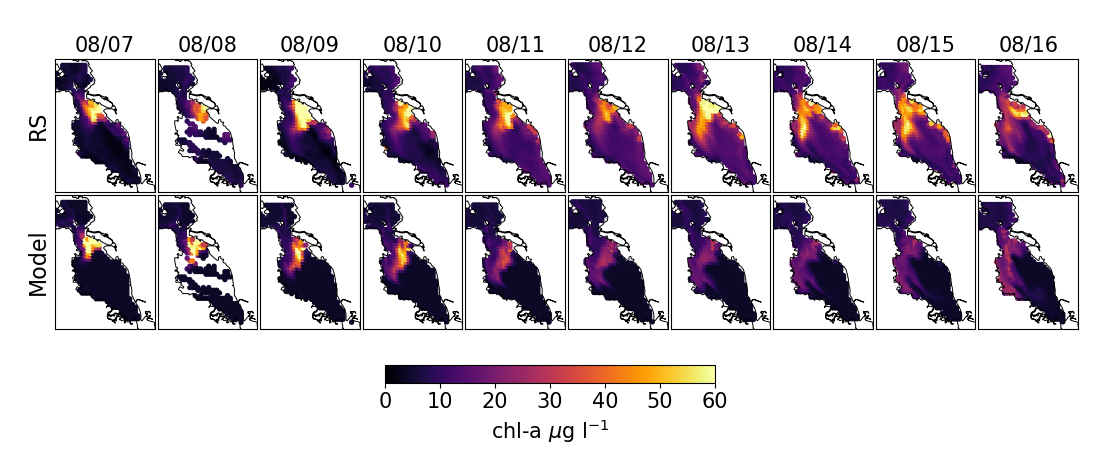

In [94]:
utils.add_to(tuner)(fig_last_eval_dense)

tuner.fig_last_eval_dense(cmap='inferno') ;

In [95]:
tg = [t for t in tracer_groups if t.tag=='v13' and t.swim==6.912j and t.initial=='alameda'][0]
tuner_6j=FitLagrangianToRS(group=tg,train_tidxs=[73,97,121,145,169,193,217,241,265,289], downsample=3)
tuner_6j.tune(minimize_kw=dict(method='Powell'))
#solveNP(thresh=0.010,c0=1.179,kprod=1.874,N0=35.000,Nsat=5.000,kmort=0.069,Isat=5.560,background=8.763) err=10.18 in 0.802s

solveNP(thresh=0.010,c0=3.000,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=19.45 in 5.138s
solveNP(thresh=0.010,c0=3.000,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=19.45 in 0.705s
solveNP(thresh=0.010,c0=2.219,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=20.47 in 0.045s
solveNP(thresh=0.010,c0=3.281,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=19.17 in 0.045s
solveNP(thresh=0.010,c0=3.938,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=18.71 in 0.045s
solveNP(thresh=0.010,c0=4.751,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=18.54 in 0.045s
solveNP(thresh=0.010,c0=4.648,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=18.54 in 0.045s
solveNP(thresh=0.010,c0=4.642,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=18.54 in 0.045s


In [84]:
# Might have had a 1h shift in RS data.
# Flyovers are 1820 UTC, which is 1120 PDT, but I've been plotting 1220 PDT 
tg = [t for t in tracer_groups if t.tag=='v13' and t.swim==6.912j and t.initial=='alameda'][0]
tidx_off=-1
tuner_6jb=FitLagrangianToRS(group=tg,
                           train_tidxs=[73+tidx_off,97+tidx_off,121+tidx_off,145+tidx_off,169+tidx_off,
                                        193+tidx_off,217+tidx_off,241+tidx_off,265+tidx_off,289+tidx_off], 
                           downsample=3)
tuner_6jb.tune(minimize_kw=dict(method='Powell'))

# With the _sfei chl imagery:
# solveNP(thresh=0.010,c0=1.364,kprod=1.784,N0=35.000,Nsat=5.000,kmort=0.067,Isat=6.102,background=8.926) err=10.08 in 0.779s
# With the _raphe chl imagery:
# solveNP(thresh=0.010,c0=1.962,kprod=1.791,N0=35.000,Nsat=5.000,kmort=0.075,Isat=4.204,background=11.407) err=15.54 in 0.769s


INFO:utils:78056/86633


solveNP(thresh=0.010,c0=3.000,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=19.29 in 5.578s
solveNP(thresh=0.010,c0=3.000,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=19.29 in 1.105s
solveNP(thresh=0.010,c0=2.219,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=20.37 in 0.045s
solveNP(thresh=0.010,c0=3.281,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=18.99 in 0.044s
solveNP(thresh=0.010,c0=3.938,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=18.48 in 0.044s
solveNP(thresh=0.010,c0=4.343,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=18.31 in 0.044s
solveNP(thresh=0.010,c0=4.789,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=18.25 in 0.045s
solveNP(thresh=0.010,c0=4.766,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=18.25 in 0.044s


/tmp/ipykernel_3147863/3287273092.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs=plt.subplots(2,len(self.snaps), figsize=(11,4.5))


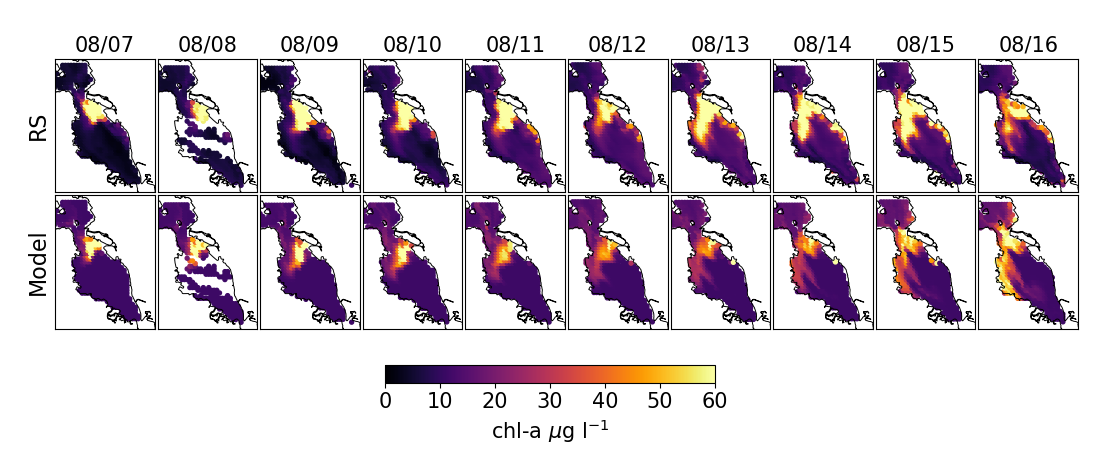

In [99]:
utils.add_to(tuner_6jb)(fig_last_eval_dense)

tuner_6jb.fig_last_eval_dense(cmap='inferno') ;

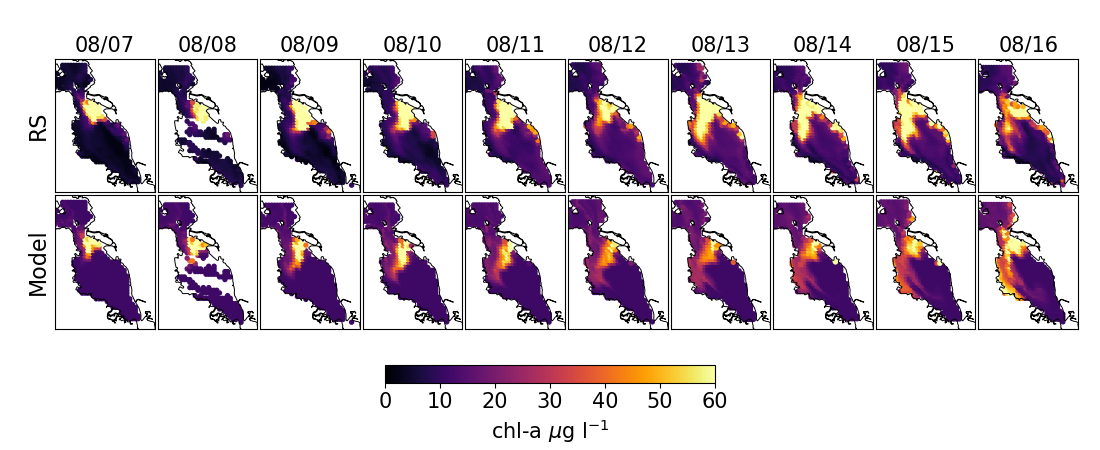

In [100]:
utils.add_to(tuner_6j)(fig_last_eval_dense)
tuner_6j.fig_last_eval_dense(cmap='inferno') ;

In [101]:
tg = [t for t in tracer_groups if t.tag=='v13' and t.swim==0.0 and t.initial=='alameda'][0]
tidx_off=-1
tuner_0=FitLagrangianToRS(group=tg,
                          # train_tidxs=[73,97,121,145,169,193,217,241,265,289],
                          train_tidxs=[73+tidx_off,97+tidx_off,121+tidx_off,145+tidx_off,169+tidx_off,
                                        193+tidx_off,217+tidx_off,241+tidx_off,265+tidx_off,289+tidx_off],
                          downsample=3)
tuner_0.tune(minimize_kw=dict(method='Powell'))
# with no offset:
# solveNP(thresh=0.010,c0=1.610,kprod=1.946,N0=35.000,Nsat=5.000,kmort=0.098,Isat=5.061,background=10.887) err=10.27 in 0.789s
# -1 offset
# solveNP(thresh=0.010,c0=2.037,kprod=1.755,N0=35.000,Nsat=5.000,kmort=0.071,Isat=7.097,background=9.615) err=10.22 in 0.779s

solveNP(thresh=0.010,c0=3.000,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=20.47 in 0.682s
solveNP(thresh=0.010,c0=3.000,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=20.47 in 0.683s
solveNP(thresh=0.010,c0=2.219,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=21.44 in 0.044s
solveNP(thresh=0.010,c0=3.281,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=20.15 in 0.044s
solveNP(thresh=0.010,c0=3.938,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=19.51 in 0.044s
solveNP(thresh=0.010,c0=4.343,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=19.18 in 0.044s
solveNP(thresh=0.010,c0=4.594,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=19.00 in 0.045s
solveNP(thresh=0.010,c0=4.749,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=18.90 in 0.044s


In [102]:
print("Change in IC scaling",2.037/1.364) 
print("Change in kprod",1.755/1.784) # 9% higher growth rate

Change in IC scaling 1.4934017595307916
Change in kprod 0.983744394618834


In [103]:
# Diffusion run!
# solveNP(thresh=0.010,c0=1.948,kprod=1.416,N0=35.000,Nsat=2.078,kmort=0.038,Isat=10.604,background=8.207) err=9.27 in 0.790s
# numerically better, esp. more physical parameter values, but visually not that great. 
tg = [t for t in tracer_groups if t.tag=='v15' and t.swim==6.912j and t.initial=='alameda'][0]
tg.ds.reload()

tidx_off=-1
tuner_diff=FitLagrangianToRS(group=tg,
                          train_tidxs=[73+tidx_off,97+tidx_off,121+tidx_off,145+tidx_off,169+tidx_off,
                                        193+tidx_off,217+tidx_off,241+tidx_off,265+tidx_off,289+tidx_off],
                          downsample=3)
tuner_diff.tune(minimize_kw=dict(method='Powell'))

INFO:utils:78130/86633


solveNP(thresh=0.010,c0=3.000,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=18.33 in 4.999s
solveNP(thresh=0.010,c0=3.000,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=18.33 in 0.705s
solveNP(thresh=0.010,c0=2.219,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=19.80 in 0.045s
solveNP(thresh=0.010,c0=3.281,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=17.85 in 0.045s
solveNP(thresh=0.010,c0=3.938,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=16.89 in 0.045s
solveNP(thresh=0.010,c0=4.343,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=16.40 in 0.045s
solveNP(thresh=0.010,c0=4.594,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=16.14 in 0.045s
solveNP(thresh=0.010,c0=4.749,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=16.00 in 0.045s


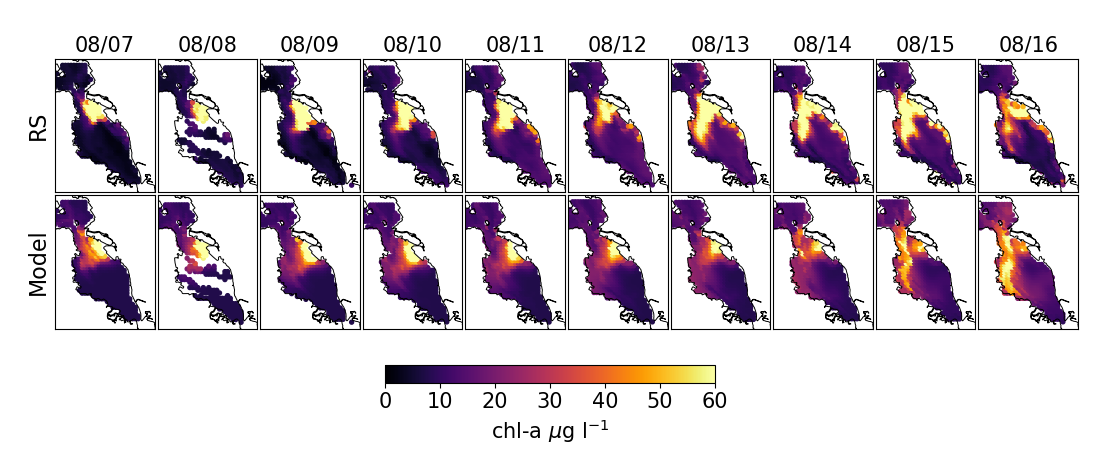

In [104]:
utils.add_to(tuner_diff)(fig_last_eval_dense)
tuner_diff.fig_last_eval_dense(cmap='inferno') ;


Other Groups
--

In [106]:
tg = [t for t in tracer_groups if t.tag=='v13' and t.swim==6.912j and t.initial=='southbay'][0]
tuner=FitLagrangianToRS(group=tg)
minimize(cost, vec0, (tuner,), method='Powell', bounds=bounds)

solveNP(thresh=0.010,c0=3.000,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=98.82 in 0.091s


NameError: name 'cost' is not defined

In [107]:
tg = [t for t in tracer_groups if t.tag=='v13' and t.swim==0.0 and t.initial=='southbay'][0]
tuner=FitLagrangianToRS(group=tg)
minimize(cost, vec0, (tuner,), method='Powell', bounds=bounds)

solveNP(thresh=0.010,c0=3.000,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=100.34 in 1.326s


NameError: name 'cost' is not defined

In [ ]:
tg = [t for t in tracer_groups if t.tag=='v13' and t.swim==6.912 and t.initial=='southbay'][0]
tuner=FitLagrangianToRS(group=tg)
minimize(cost, vec0, (tuner,), method='Powell', bounds=bounds)